In [15]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
import scipy.integrate as integrate
import numba
# to print plots inline
%matplotlib inline

In [16]:
# specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
betafirm = (1 / (1 + r))
sigma_z = 0.213
mu = 0.0
rho = 0.7605
sizez = 9
#sigma_eps = 0.2
sigma_eps = sigma_z*((1 - rho ** 2) ** (1 / 2))

In [17]:
# Compute cut-off values
N = sizez  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)
# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
z_grid = np.exp(z_grid)
print('Grid points = ', z_grid)
# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
#print('Transition matrix = ', pi)
print('pi sums = ', pi.sum(axis=0), pi.sum(axis=1))


Cut-off values =  [       -inf -0.25999639 -0.16288316 -0.09174491 -0.02975829  0.02975829
  0.09174491  0.16288316  0.25999639         inf]
Grid points =  [ 0.69553746  0.81235765  0.88149515  0.94145935  1.          1.06218075
  1.13443619  1.2309849   1.43773709]
Transition matrix =  [[  5.34646999e-01   2.33099908e-01   1.19241334e-01   6.16948412e-02
    3.06368282e-02   1.38694209e-02   5.27307457e-03   1.39972319e-03
    1.37871226e-04]
 [  2.33099908e-01   2.53066831e-01   1.95990939e-01   1.38221479e-01
    8.98690322e-02   5.26608516e-02   2.62024217e-02   9.48881413e-03
    1.39972319e-03]
 [  1.19241334e-01   1.95990939e-01   1.96744233e-01   1.70765394e-01
    1.33994761e-01   9.44950201e-02   5.72928238e-02   2.62024217e-02
    5.27307457e-03]
 [  6.16948412e-02   1.38221479e-01   1.70765394e-01   1.75481409e-01
    1.60693238e-01   1.32118347e-01   9.44950201e-02   5.26608516e-02
    1.38694209e-02]
 [  3.06368282e-02   8.98690322e-02   1.33994761e-01   1.60693238e-01
  

In [18]:
'''
kvec is the vector of k's
sizek is the size of the k's grid points

'''
dens = 5
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **   
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]


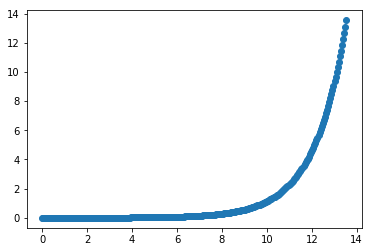

In [19]:
k_linear = np.linspace(lb_k, ub_k, num=sizek)
plt.scatter(k_linear, kvec)

In [20]:

'''

i: the index for k
j: the index for z
h: the index for k_prime

'''

# operating profits, op
op  = np.zeros((sizek, sizez), dtype = np.float)
for i in range(sizek):
    for j in range(sizez):
        op[i, j] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
                   ((z_grid[j])**(1/(1 - alpha_l))) * 
                   ((kvec[i] ** alpha_k) ** (1 / (1 - alpha_l))))

        
        

# firm cash flow, e
e = np.zeros((sizek, sizez, sizek), dtype = np.float)
for i in range(sizek):
    for j in range(sizez):
        for h in range(sizek):
            e[i, j, h] = (op[i,j] - kvec[h] + ((1 - delta) * kvec[i]) -
                       ((psi / 2) * ((kvec[h] - ((1 - delta) * kvec[i])) ** 2)
                        / kvec[i]))


In [21]:
VFtol = 1e-6    #tolerance to determine convergence
VFdist = 7.0    #variable to store the distance between two Vs
VFmaxiter = 3000
V = np.zeros((sizek, sizez))  # initial guess at value function
Vmat = np.zeros((sizek, sizez, sizek))  # initialize Vmat matrix
Vstore = np.zeros((sizek, sizez, VFmaxiter))  # initialize Vstore array
VFiter = 1


In [22]:
'''
There are not variables, quite confusing.... let's sort it out
V          : vector of current values of value function
Vmat       : V[i, j, h] is the value function of 
Vstore     : store value function at each iteration


'''

# we separate this function out from the while loop to use numba to speed it up.

@numba.jit
def Vmat_iter(sizek, sizez, Vmat, e, betafirm, pi, V):
    for i in range(sizek):  # loop over k
            for j in range(sizez):  # loop over z
                for h in range(sizek): #loop over k'
                    Vmat[i, j, h] = e[i, j, h] + betafirm*np.dot(pi[j,:], V[h, :].reshape(sizez,))
    return Vmat

In [23]:
start_time = time.clock()
while (VFdist > VFtol) and (VFiter < VFmaxiter):
    TV = V
    Vmat = Vmat_iter(sizek, sizez, Vmat, e, betafirm, pi, V)
    Vstore[:, :, VFiter] = V.reshape(sizek, sizez)  # store value function at each
    # iteration for graphing later
    V = np.max(Vmat,axis= 2)
    PF = np.argmax(Vmat, axis= 2)
    VFdist = (np.absolute(V - TV)).max()
    VFiter += 1
    #print(VFiter, VFdist)
    

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')
VF = V

Value function converged after this many iterations: 345
VFI took  32.64137903364261  seconds to solve


In [24]:
'''
------------------------------------------------------------------------
Find optimal capital and investment policy functions
------------------------------------------------------------------------
optK = (sizek,) vector, optimal choice of k' for each k
optI = (sizek,) vector, optimal choice of investment for each k
------------------------------------------------------------------------
'''
optK = np.zeros_like(PF, dtype = np.float)
optI = np.zeros_like(PF, dtype = np.float)
for i in range(sizez):
    optK[:, i] = kvec[PF[:,i]]
    optI[:, i] = optK[:,i] - (1 - delta)*kvec


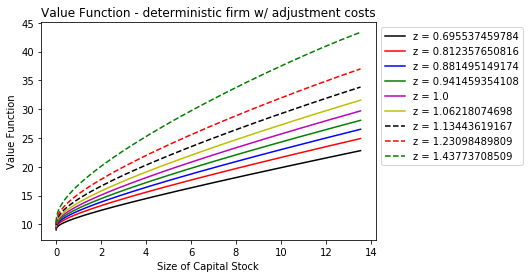

In [25]:
vf_fig = plt.figure()
plt.plot(kvec, VF[:,0], 'k', label = "z = "+str(z_grid[0]))
plt.plot(kvec, VF[:,1], 'r',label = "z = "+str(z_grid[1]))
plt.plot(kvec, VF[:,2], 'b',label = "z = "+str(z_grid[2]))
plt.plot(kvec, VF[:,3], 'g',label = "z = "+str(z_grid[3]))
plt.plot(kvec, VF[:,4], 'm',label = "z = "+str(z_grid[4]))
plt.plot(kvec, VF[:,5], 'y',label = "z = "+str(z_grid[5]))
plt.plot(kvec, VF[:,6], 'k--',label = "z = "+str(z_grid[6]))
plt.plot(kvec, VF[:,7], 'r--',label = "z = "+str(z_grid[7]))
plt.plot(kvec, VF[:,8], 'g--',label = "z = "+str(z_grid[8]))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')
plt.show()

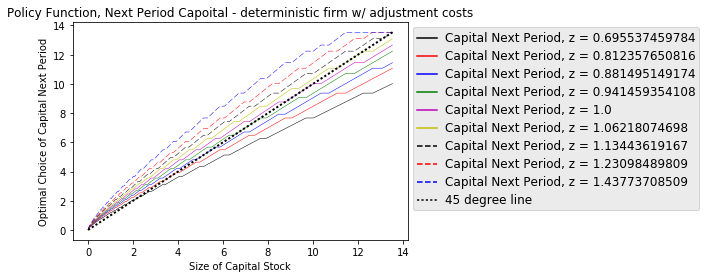

In [26]:
# Plot optimal capital stock rule as a function of firm size
PF_fig = plt.figure()
fig, ax = plt.subplots()
ax.plot(kvec, optK[:, 0], 'k', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[0]))
ax.plot(kvec, optK[:, 1], 'r', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[1]))
ax.plot(kvec, optK[:, 2], 'b', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[2]))
ax.plot(kvec, optK[:, 3], 'g', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[3]))
ax.plot(kvec, optK[:, 4], 'm', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[4]))
ax.plot(kvec, optK[:, 5], 'y', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[5]))
ax.plot(kvec, optK[:, 6], 'k--', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[6]))
ax.plot(kvec, optK[:, 7], 'r--', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[7]))
ax.plot(kvec, optK[:, 8], 'b--', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[8]))
ax.plot(kvec, kvec, 'k:', lw = 2, label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')
plt.show()

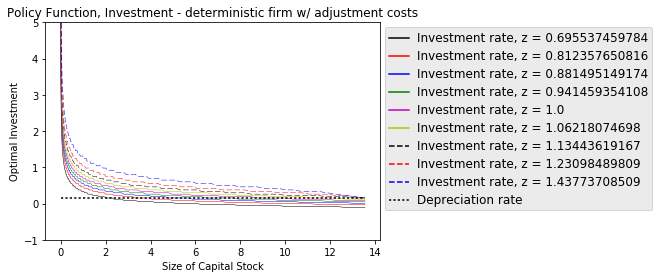

In [27]:
# Plot investment rule as a function of firm size
inv_fig = plt.figure()
fig, ax = plt.subplots()
ax.plot(kvec, optI[:, 0]/kvec, 'k-', lw = 0.5, label='Investment rate, z = '+str(z_grid[0]))
ax.plot(kvec, optI[:, 1]/kvec, 'r', lw = 0.5, label='Investment rate, z = '+str(z_grid[1]))
ax.plot(kvec, optI[:, 2]/kvec, 'b', lw = 0.5, label='Investment rate, z = '+str(z_grid[2]))
ax.plot(kvec, optI[:, 3]/kvec, 'g', lw = 0.5, label='Investment rate, z = '+str(z_grid[3]))
ax.plot(kvec, optI[:, 4]/kvec, 'm', lw = 0.5, label='Investment rate, z = '+str(z_grid[4]))
ax.plot(kvec, optI[:, 5]/kvec, 'y', lw = 0.5, label='Investment rate, z = '+str(z_grid[5]))
ax.plot(kvec, optI[:, 6]/kvec, 'k--', lw = 0.5, label='Investment rate, z = '+str(z_grid[6]))
ax.plot(kvec, optI[:, 7]/kvec, 'r--', lw = 0.5, label='Investment rate, z = '+str(z_grid[7]))
ax.plot(kvec, optI[:, 8]/kvec, 'b--', lw = 0.5, label='Investment rate, z = '+str(z_grid[8]))
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.ylim(-1, 5)
plt.title('Policy Function, Investment - deterministic firm w/ adjustment ' +
          'costs')
plt.show()

## 7. References
* Stokey, Nancy L. and Robert E. Lucas and Edward C. Prescott, *Recursive Methods in Economic Dynamics*, Harvard University Press (1989).

In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
